## Time Series Prediction using LSTM RNN

In [1]:
# in this code block we gather all imports

# to read CSV and for use with the library ppscore
import pandas as pd
from pandas.api.types import CategoricalDtype

# for use with sklearn and for EDA
import numpy as np

# Data Split
from sklearn.model_selection import train_test_split

# Normalization and Standardization
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Plots
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm

# EDA
import ppscore as pps
from scipy import stats

# PCA
from sklearn.decomposition import PCA

# Tensors and Artificial Neural Networks
import torch
import torch.nn as nn



In [2]:
# in this code block we determine the device to use depending on GPU availability

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}.'.format(device))

This Computation is running on cpu.


In [3]:
# in this code block we generate a series bases on the sinus function

def create_example_sinus_time_series():
    # number of samples == number of time series
    n = 10
    # number of test samples == number of test time series
    n_test = 3
    # number of train samples = number of train time series
    n_train = 10 - n_test
    # number of actual values per time series
    n_values = 1000
    # parameter that governs the width of a sine wave
    sine_wave_width = 20
    
    # create some input for the sine function
    x = np.empty((n, n_values), np.float32)
    x[:] = np.array(range(n_values)) + np.random.randint(-4 * sine_wave_width, 4 * sine_wave_width, n).reshape(n, 1)

    print(f"x.shape={x.shape}")

    # get the corresponding sine values
    y = np.sin(x / 1.0 / sine_wave_width).astype(np.float32)

    print(f"y.shape={y.shape}")

    # plot of the first sine wave n = 1 and second sine wave n = 2
    plt.figure(figsize=(16,9))
    plt.title("Sine wave examples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(np.arange(x.shape[1]), y[0,:], linestyle='',marker='.',markersize=11.,markerfacecolor='#8080ff',markeredgewidth=.0)
    plt.plot(np.arange(x.shape[1]), y[1,:], linestyle='',marker='.',markersize=11.,markerfacecolor='#ffb380',markeredgewidth=.0)
    plt.show()

    train_series_input_np = y[n_test:, :-1]
    train_series_input = torch.from_numpy(train_series_input_np)
    print(f"train_series.shape={train_series_input.shape}")
    assert train_series_input_np.shape[0] == n_train
    assert train_series_input_np.shape[1] == n_values - 1

    train_series_target_np = y[n_test:, 1:]
    train_series_target = torch.from_numpy(train_series_target_np)
    print(f"train_series_target.shape={train_series_target.shape}")
    assert train_series_target_np.shape[0] == n_train
    assert train_series_target_np.shape[1] == n_values - 1

    test_series_input_np = y[:n_test, :-1]
    test_series_input = torch.from_numpy(test_series_input_np)
    print(f"test_series_input.shape={test_series_input.shape}")
    assert test_series_input_np.shape[0] == n_test
    assert test_series_input_np.shape[1] == n_values - 1

    test_series_target_np = y[:n_test, 1:]
    test_series_target = torch.from_numpy(test_series_target_np)
    print(f"test_series_target.shape={test_series_target.shape}")
    assert test_series_target_np.shape[0] == n_test
    assert test_series_target_np.shape[1] == n_values - 1

    return y, train_series_input, train_series_target, test_series_input, test_series_target


In [4]:
# in this code block we define a long short-term memory recurrent neural network

class OneLayerLSTMTimeSeriesPredictor(nn.Module):
    def __init__(self, n_hidden=64):
        super(OneLayerLSTMTimeSeriesPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm, lstm, linear
        # 1 input since in each step we consume only 1 value of a time series
        self.lstm_1 = nn.LSTMCell(1, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        # 1 output since in each step we predict only 1 value of a time series

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        # initial hidden states of LSTM cell 1
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(h_t)
        # initial cell states of LSTM cell 1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(c_t)

        # split tensor into chunks
        # technically each chunk is a view on the tensor
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm_1(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm_1(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs.append(output)            

        outputs = torch.cat(outputs, dim=1)
        return outputs


In [5]:
# in this code block we define a multi-layer long short-term memory recurrent neural network

class MultiLayerLSTMTimeSeriesPredictor(nn.Module):
    def __init__(self, n_hidden=64):
        super(MultiLayerLSTMTimeSeriesPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm, lstm, linear
        # 1 input since in each step we consume only 1 value of a time series
        self.lstm_1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm_2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        #self.lstm_3 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        # 1 output since in each step we predict only 1 value of a time series

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        # initial hidden states of LSTM cell 1
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(h_t)
        # initial cell states of LSTM cell 1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(c_t)
        # initial hidden states of LSTM cell 2
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(h_t2)
        # initial cell states of LSTM cell 2
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        torch.nn.init.xavier_normal_(c_t2)
        # initial cell states of LSTM cell 3
        #h_t3 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        #torch.nn.init.xavier_normal_(h_t3)
        # initial cell states of LSTM cell 3
        #c_t3 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        #torch.nn.init.xavier_normal_(c_t3)

        for input_t in x.split(1, dim=1):
            # input_t.shape n_test, 1
            h_t, c_t = self.lstm_1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            #h_t3, c_t3 = self.lstm_3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm_1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            #h_t3, c_t3 = self.lstm_3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t2)
            outputs.append(output)            

        outputs = torch.cat(outputs, dim=1)
        return outputs


x.shape=(10, 1000)
y.shape=(10, 1000)


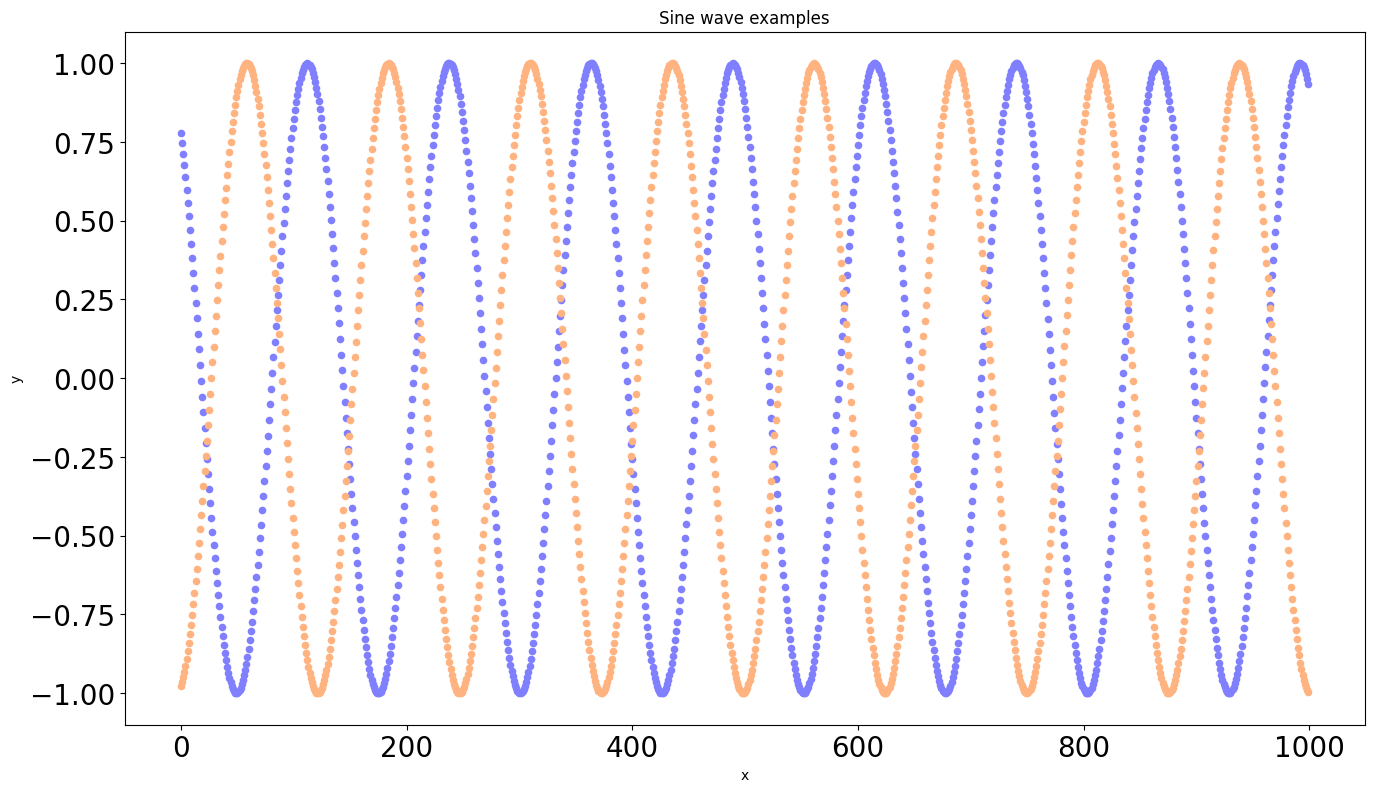

train_series.shape=torch.Size([7, 999])
train_series_target.shape=torch.Size([7, 999])
test_series_input.shape=torch.Size([3, 999])
test_series_target.shape=torch.Size([3, 999])
epoch=0
train loss: 0.4993669092655182
train loss: 0.49895545840263367
train loss: 0.49519768357276917
train loss: 0.48742109537124634
train loss: 0.4723006784915924
train loss: 0.4425157606601715
train loss: 0.395171195268631
train loss: 0.3590483069419861
train loss: 0.3315386176109314
train loss: 0.2989640235900879
train loss: 0.2673604488372803
train loss: 0.24363656342029572
train loss: 0.21886923909187317
train loss: 0.18917614221572876
train loss: 0.15738344192504883
train loss: 0.12683655321598053
train loss: 0.09955166280269623
train loss: 0.07840031385421753
train loss: 0.06270480901002884
train loss: 0.05141843110322952
test loss: 0.0433131642639637
epoch=1
train loss: 0.043260976672172546
train loss: 0.03687690198421478
train loss: 0.032076504081487656
train loss: 0.028200075030326843
train loss: 0.

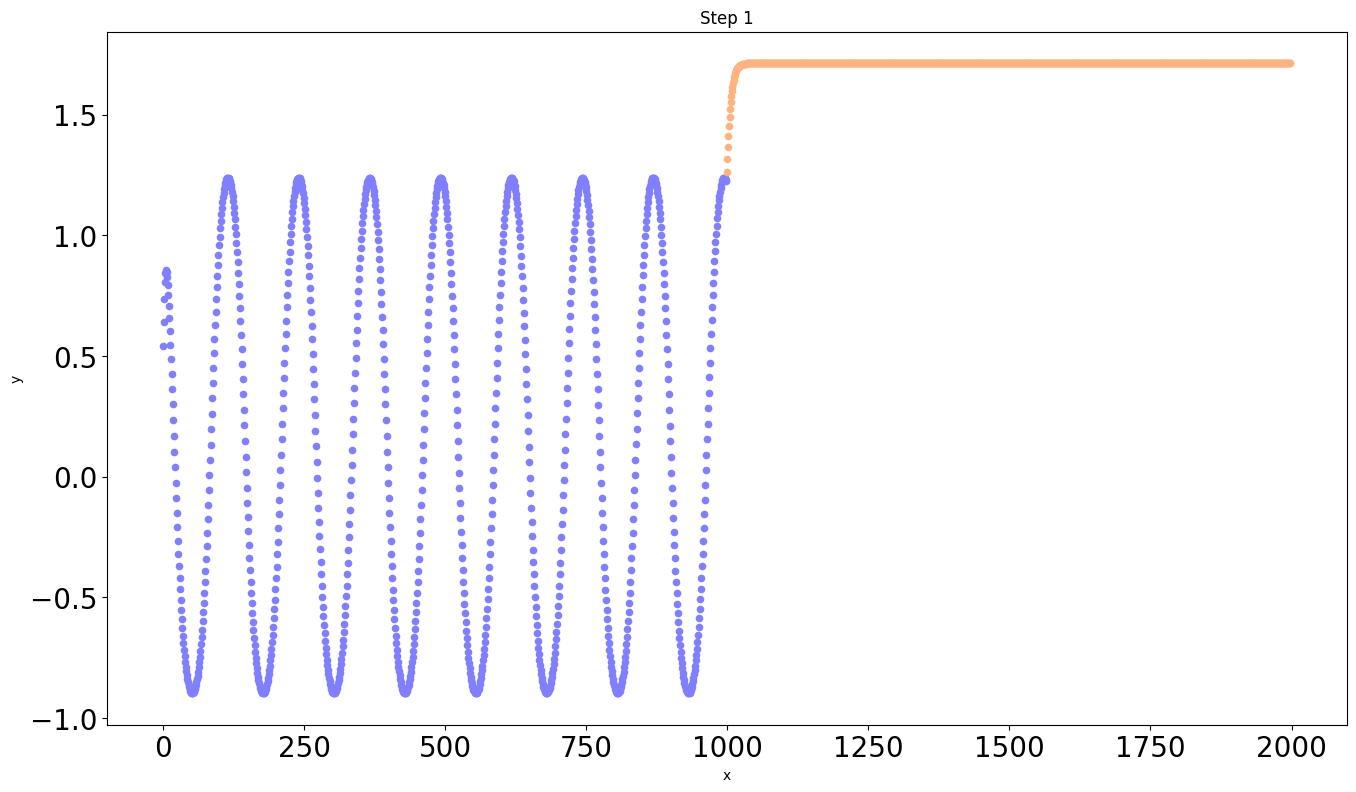

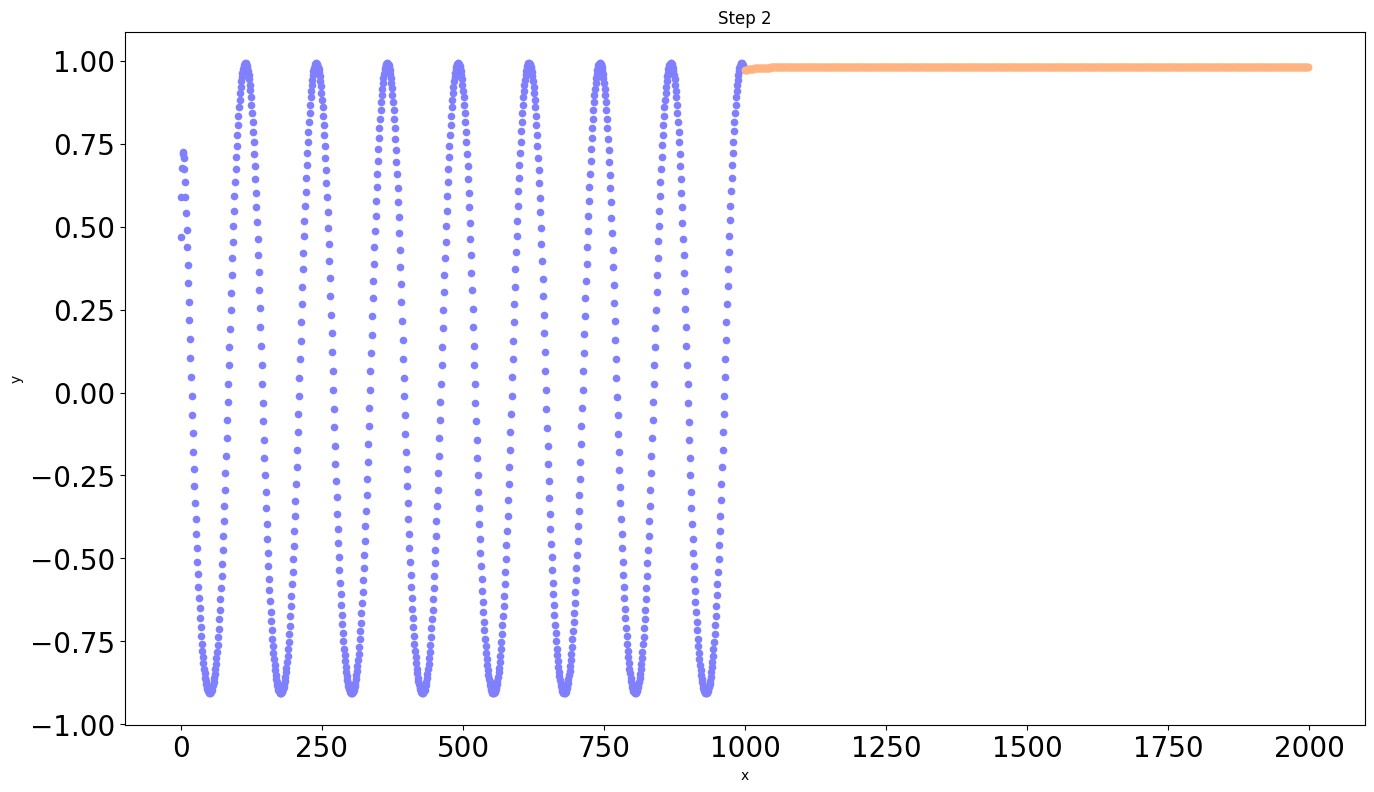

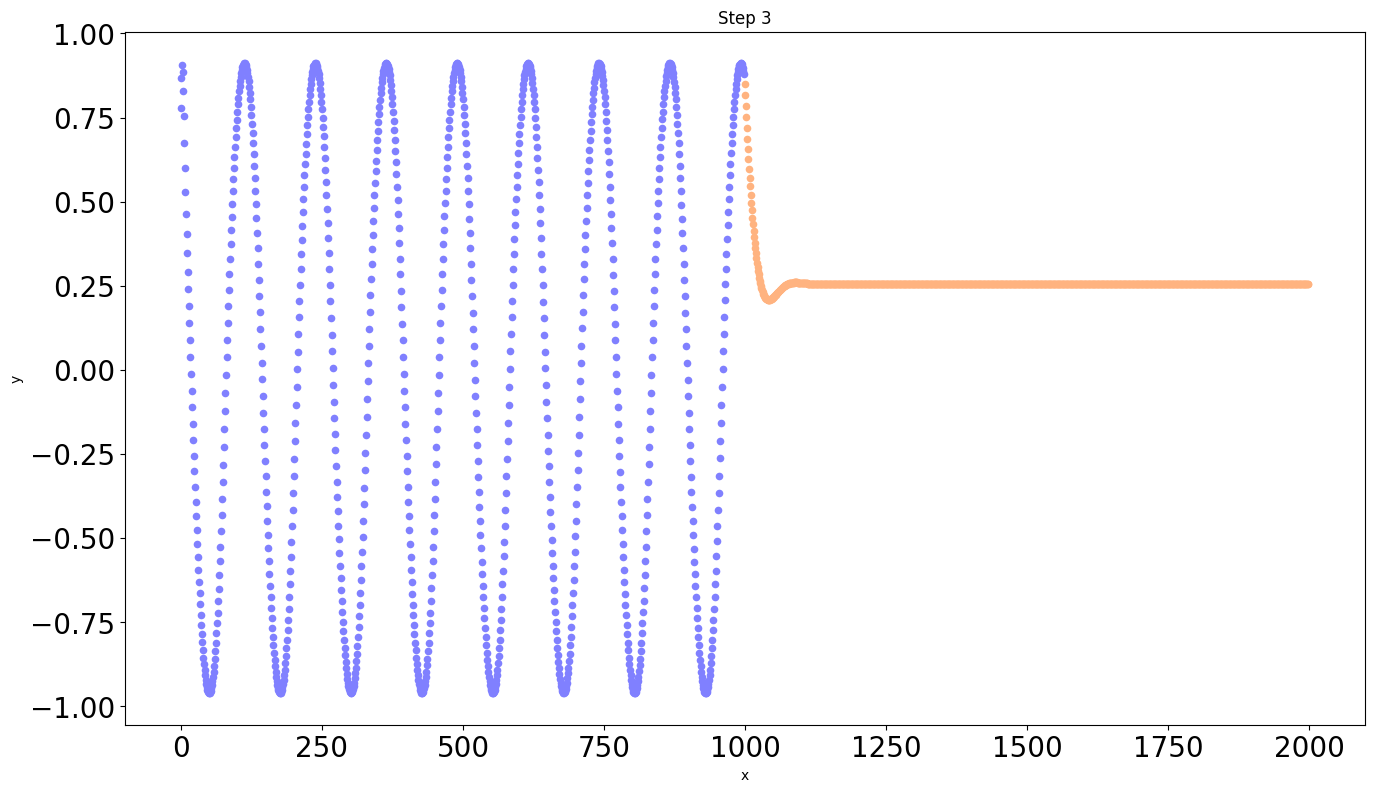

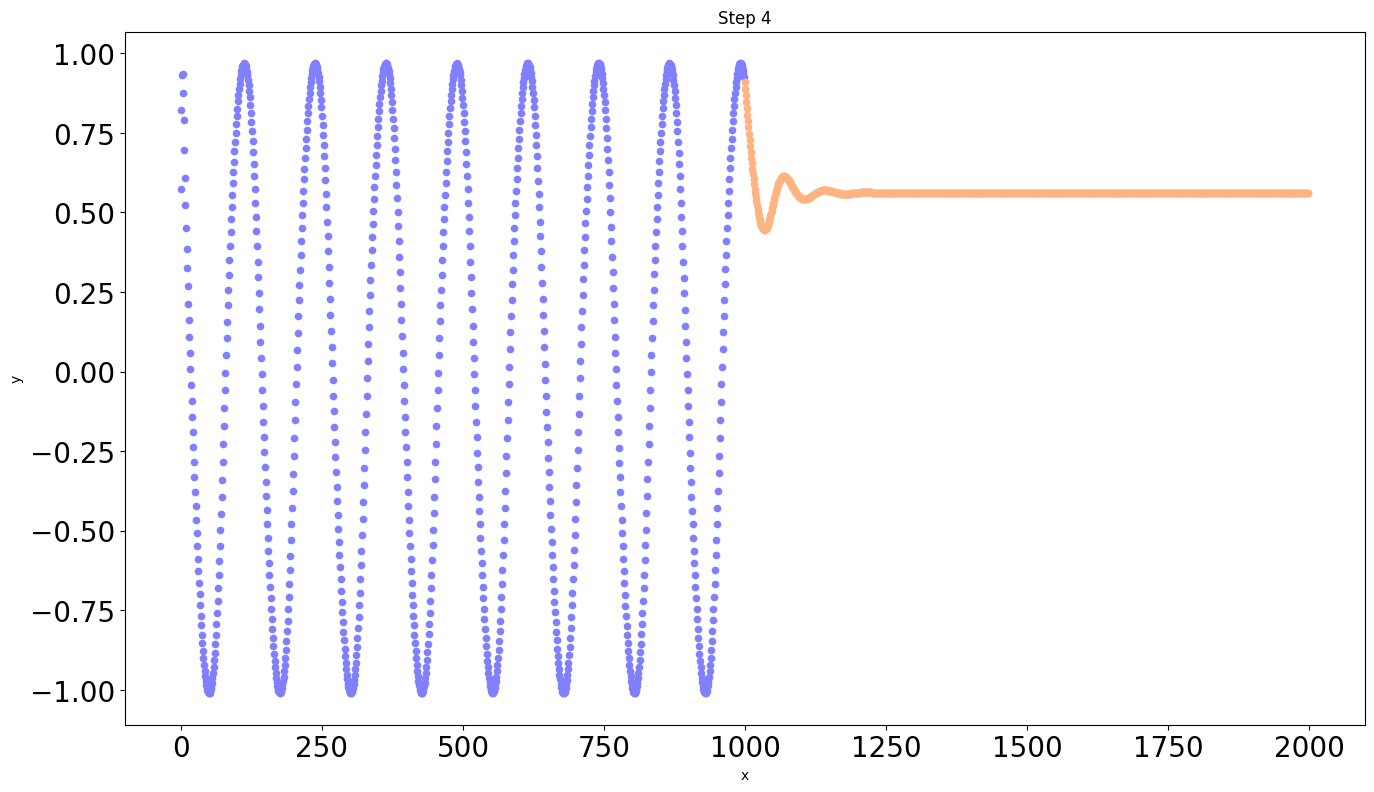

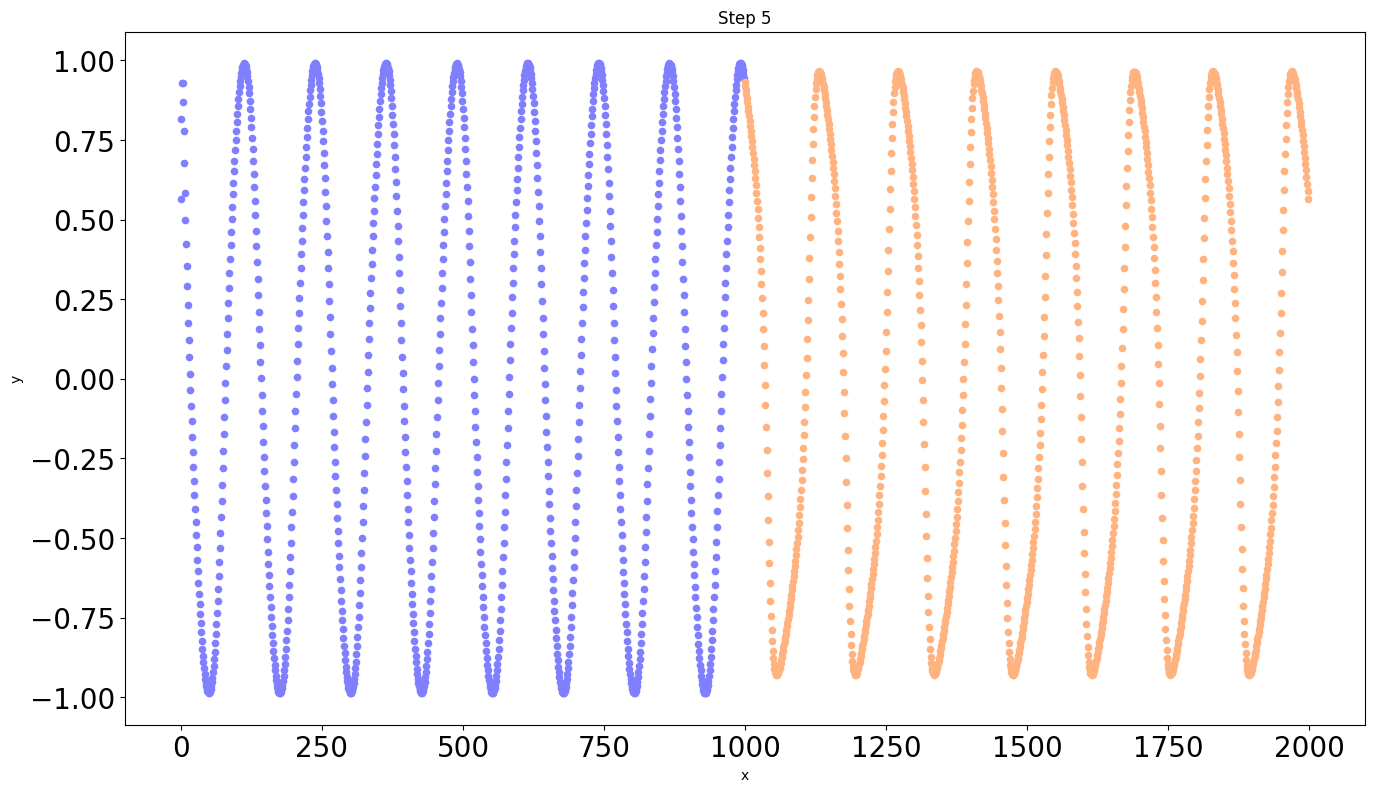

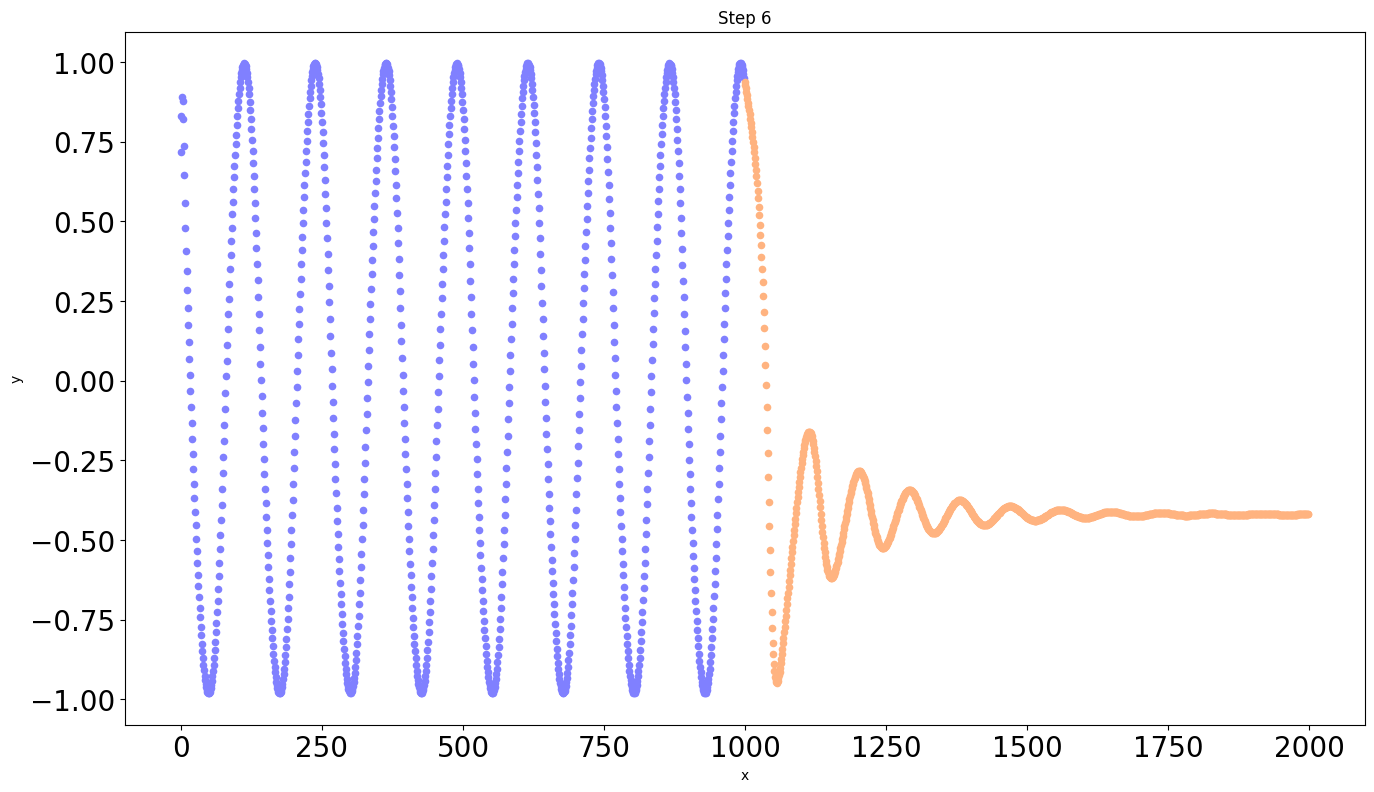

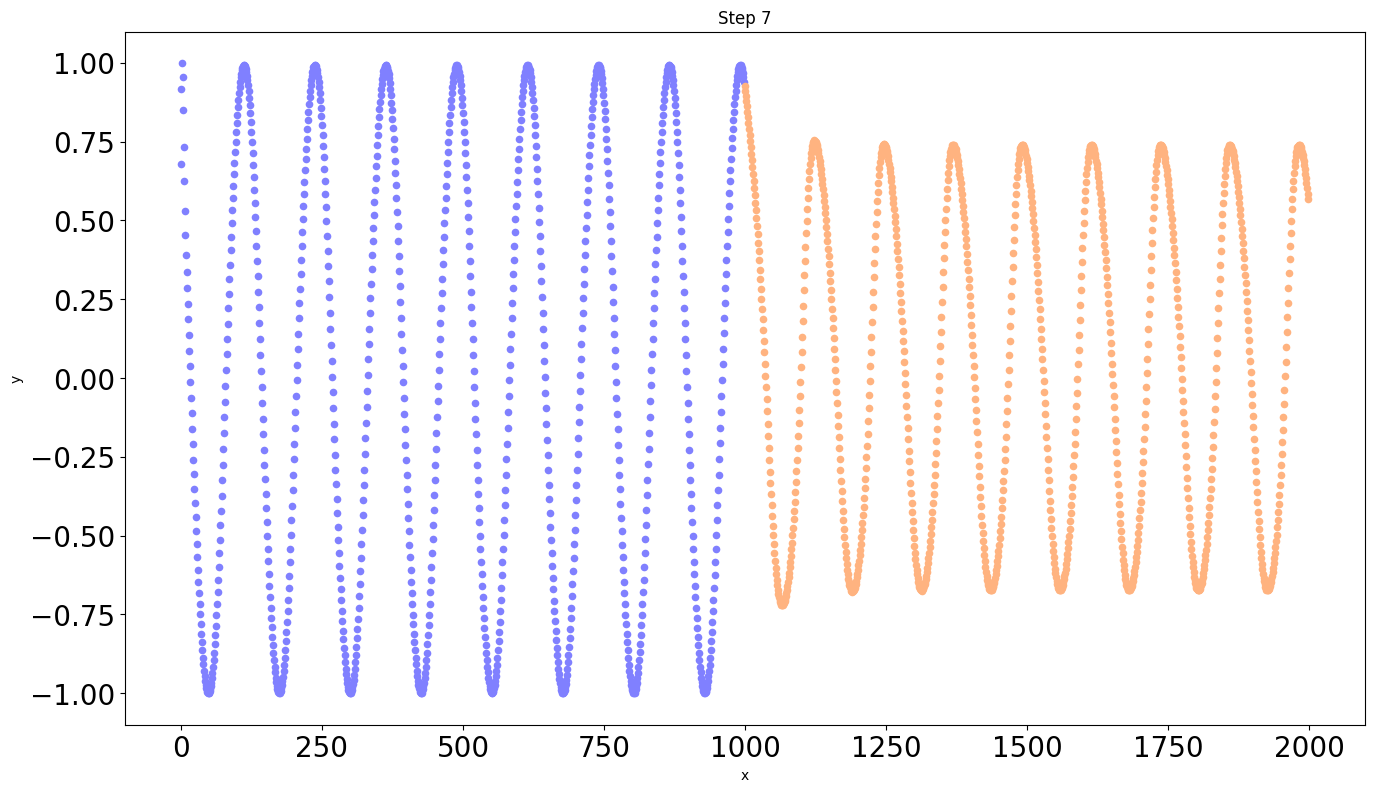

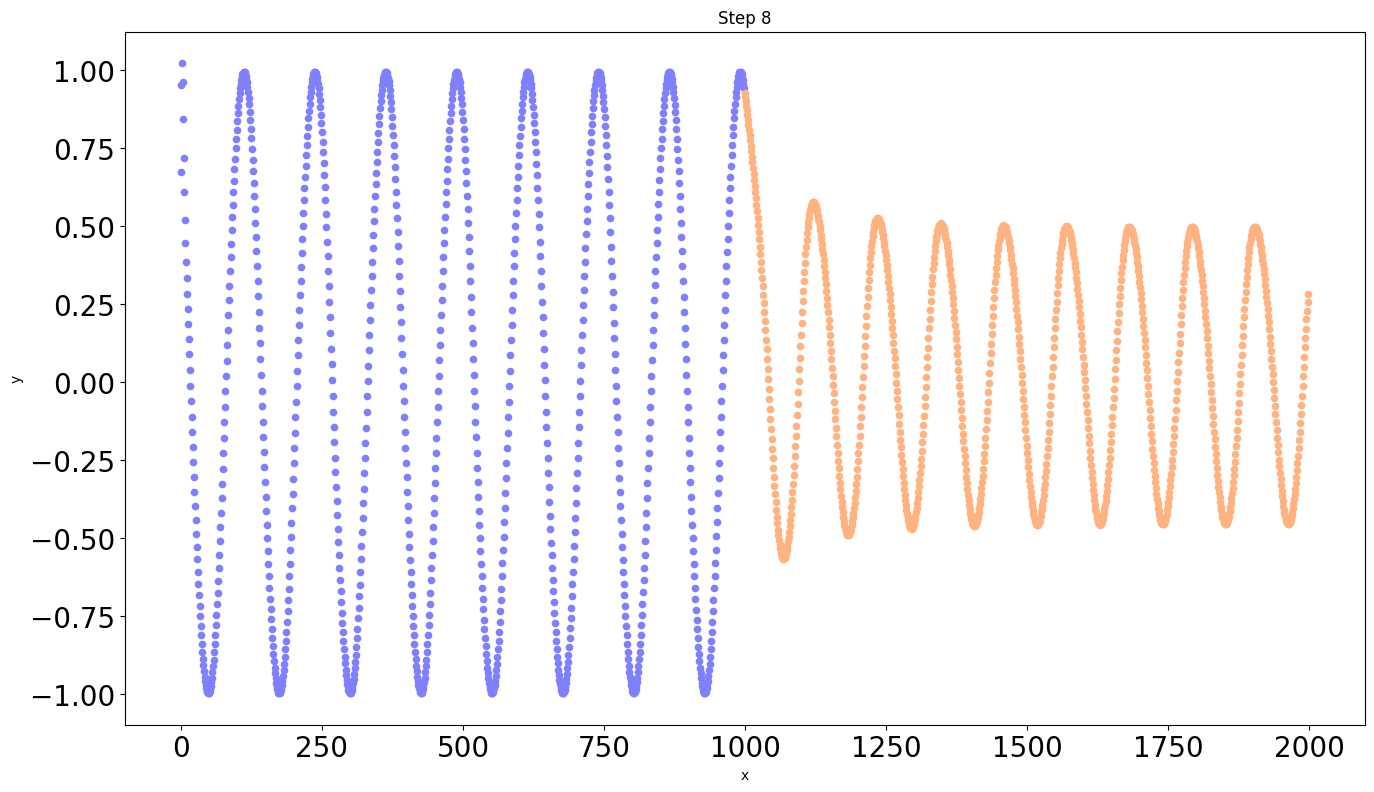

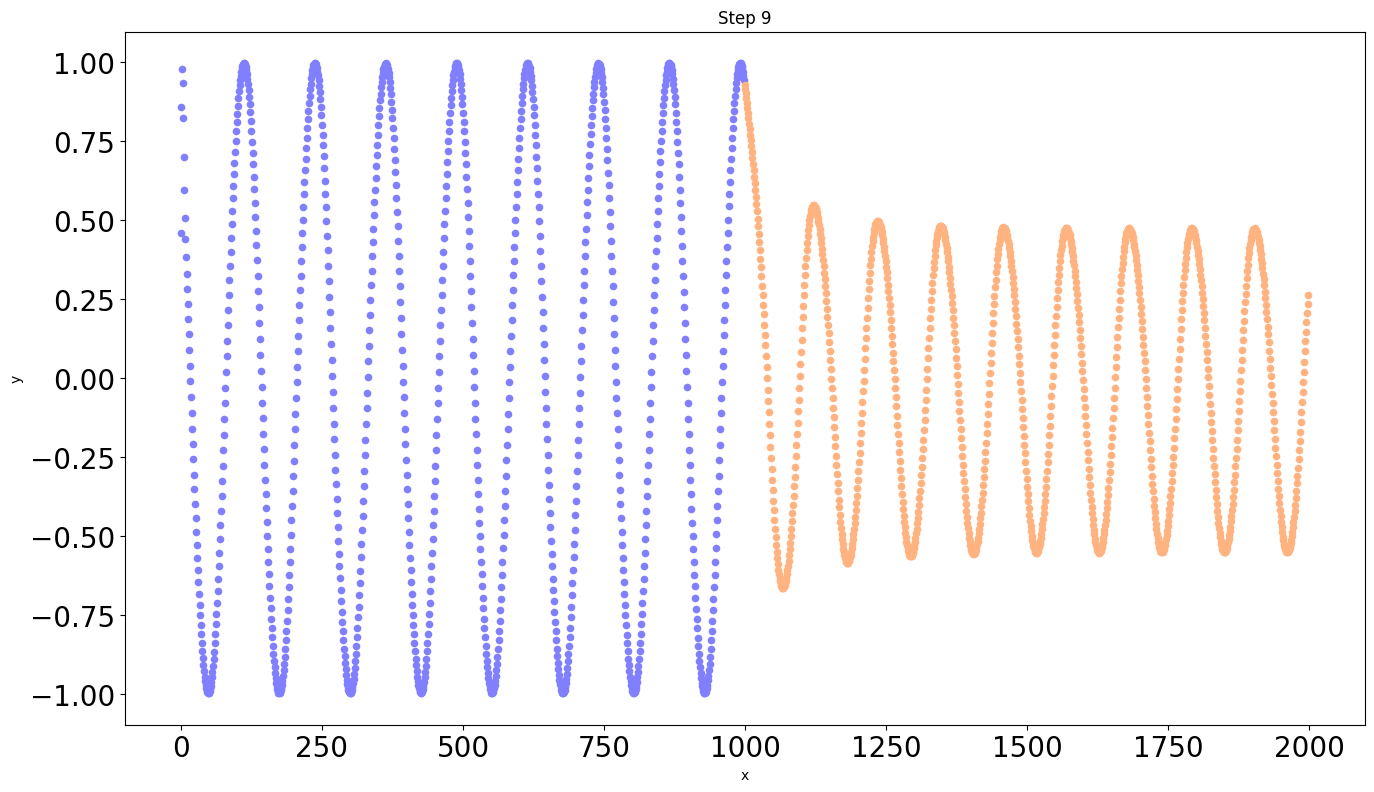

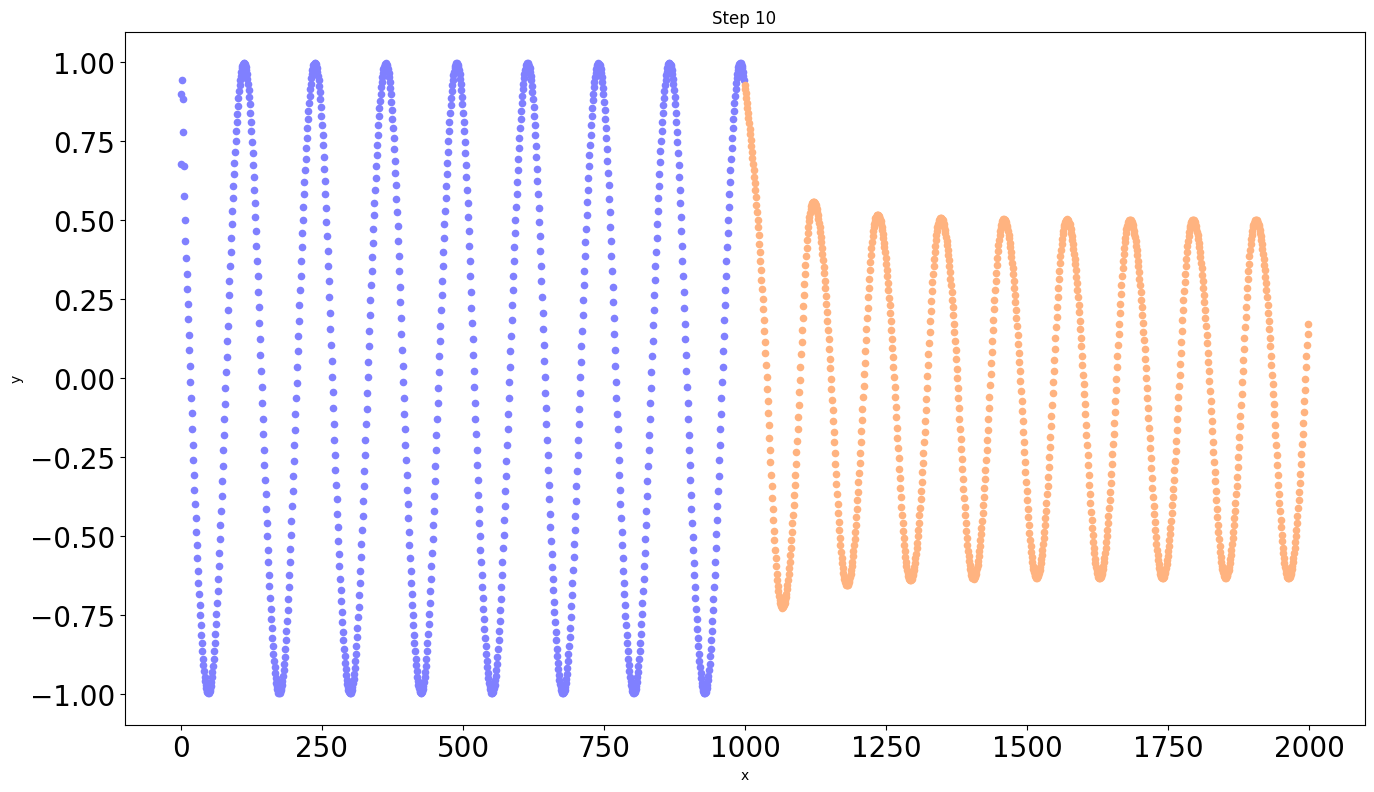

In [6]:
# in this code we train and test the LSTM NN

y, train_series_input, train_series_target, test_series_input, test_series_target = create_example_sinus_time_series()

model = MultiLayerLSTMTimeSeriesPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)

n_epochs = 10
for epoch_i in range(n_epochs):
    print(f"epoch={epoch_i}")

    # train
    def closure():
        optimizer.zero_grad()
        out_i = model(train_series_input)
        l_train_i = criterion(out_i, train_series_target)
        print('train loss:', l_train_i.item())
        l_train_i.backward()
        return l_train_i
    
    optimizer.step(closure)

    # predict
    with torch.no_grad():
        n_future_values=1000
        y_test_i = model(test_series_input, future=n_future_values)
        l_test = criterion(y_test_i[:, :-n_future_values], test_series_target)
        print('test loss:', l_test.item())
        y_test_i_np = y_test_i.detach().numpy()

    # plot of the first sine wave n = 1 and second sine wave n = 2
    plt.figure(figsize=(16,9))
    plt.title(f"Step {epoch_i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    n_train_values = train_series_input.shape[1] # 999
    def draw(y_np):
        # draw the actual values
        plt.plot(np.arange(n_train_values), y_np[:n_train_values], linestyle='', marker='.', markersize=11., markerfacecolor='#8080ff', markeredgewidth=.0)
        # draw the predicted values
        plt.plot(np.arange(n_train_values, n_train_values + n_future_values), y_np[n_train_values:], linestyle='', marker='.', markersize=11., markerfacecolor='#ffb380', markeredgewidth=.0)
    
    draw(y_test_i_np[0])

